# Edge-IIoTset APT / Intrusion Detection – Python ML Pipeline

This notebook builds a **Python-based machine learning model** for intrusion / APT-style attack detection
on the **Edge-IIoTset** dataset (DNN-EdgeIIoT-dataset.csv), following the proposed methodology:

1. Dataset acquisition (from Kaggle) and loading.
2. Data cleaning and pre-processing (dropping unused columns, removing missing / duplicate rows).
3. Categorical feature encoding (dummy/one-hot).
4. Train–test split and feature scaling.
5. Training a **lightweight Random Forest classifier** as the core ML detection module.
6. Evaluation with multi-class metrics and confusion matrix.
7. Feature importance inspection for edge-friendliness.
8. Saving the trained model and scaler for later edge / gateway deployment.

Dataset reference (you **must cite this in your thesis/report**):

> Mohamed Amine Ferrag, Othmane Friha, Djallel Hamouda, Leandros Maglaras, Helge Janicke, 
> **"Edge-IIoTset: A New Comprehensive Realistic Cyber Security Dataset of IoT and IIoT Applications for Centralized and Federated Learning"**, TechRxiv, 2022, doi:10.36227/techrxiv.18857336.v1.


## 0. Imports and utility functions


In [6]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import joblib

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

print("Libraries imported.")


Libraries imported.


## 1. Download Edge-IIoTset from Kaggle (Colab-friendly)

This cell assumes you are running on **Google Colab** and have a valid `kaggle.json` API token.
If you already downloaded the dataset manually, you can **skip this cell** and place
`DNN-EdgeIIoT-dataset.csv` in the same directory as this notebook.


In [8]:
# If running on Google Colab, uncomment and run this cell once.
# It will download the DNN-EdgeIIoT-dataset.csv file from Kaggle.

# from google.colab import files
# !pip install -q kaggle
# files.upload()  # upload your kaggle.json

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot \
#   -f "Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv"

# # The downloaded file is a zip named 'DNN-EdgeIIoT-dataset.csv.zip'
# !unzip DNN-EdgeIIoT-dataset.csv.zip
# !rm DNN-EdgeIIoT-dataset.csv.zip

print("If you already have DNN-EdgeIIoT-dataset.csv, you can skip this cell.")


If you already have DNN-EdgeIIoT-dataset.csv, you can skip this cell.


## 2. Load the DNN-EdgeIIoT dataset


In [9]:
# Adjust the path if your CSV is in a different folder.
csv_path = 'DNN-EdgeIIoT-dataset.csv'
df = pd.read_csv(csv_path, low_memory=False)

print("Raw dataset shape:", df.shape)
df.head()


Raw dataset shape: (2219201, 63)


,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,icmp.unused,http.file_data,http.content_length,http.request.uri.query,http.request.method,http.referer,http.request.full_uri,http.request.version,http.response,http.tls_port,tcp.ack,tcp.ack_raw,tcp.checksum,tcp.connection.fin,tcp.connection.rst,tcp.connection.syn,tcp.connection.synack,tcp.dstport,tcp.flags,tcp.flags.ack,tcp.len,tcp.options,tcp.payload,tcp.seq,tcp.srcport,udp.port,udp.stream,udp.time_delta,dns.qry.name,dns.qry.name.len,dns.qry.qu,dns.qry.type,dns.retransmission,dns.retransmit_request,dns.retransmit_request_in,mqtt.conack.flags,mqtt.conflag.cleansess,mqtt.conflags,mqtt.hdrflags,mqtt.len,mqtt.msg_decoded_as,mqtt.msg,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,2021 11:44:10.081753000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.153346e+09,47892.0,0.0,0.0,0.0,1.0,64855.0,18.0,1.0,0.0,020405b40101040201030307,0,0.0,1883.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,2021 11:44:10.162218000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.447945e+08,16077.0,0.0,0.0,0.0,0.0,1883.0,24.0,1.0,14.0,0,100c00044d5154540402003c0000,1.0,64855.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,2.0,16.0,12.0,0.0,0,1.0,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,2021 11:44:10.162271000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,62675.0,0.0,0.0,0.0,0.0,64855.0,16.0,1.0,0.0,0,0,1.0,1883.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,2021 11:44:10.162641000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,54469.0,0.0,0.0,0.0,0.0,64855.0,24.0,1.0,4.0,0,20020000,1.0,1883.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0x00000000,0.0,0.0,32.0,2.0,0.0,0,2.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,2021 11:44:10.166132000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.447945e+08,53812.0,0.0,0.0,0.0,0.0,1883.0,24.0,1.0,41.0,0,3027001854656d70657261747572655f616e645f48756d...,15.0,64855.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,48.0,39.0,0.0,32342e36382037362e34320d0a,3.0,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal


In [10]:
# Inspect the attack type distribution
if 'Attack_type' in df.columns:
    print(df['Attack_type'].value_counts())
else:
    print("Column 'Attack_type' not found. Please check the dataset schema.")


Attack_type
Normal                   1615643
DDoS_UDP                  121568
DDoS_ICMP                 116436
SQL_injection              51203
Password                   50153
Vulnerability_scanner      50110
DDoS_TCP                   50062
DDoS_HTTP                  49911
Uploading                  37634
Backdoor                   24862
Port_Scanning              22564
XSS                        15915
Ransomware                 10925
MITM                        1214
Fingerprinting              1001
Name: count, dtype: int64


## 3. Data cleaning and column dropping

Following the dataset README, we drop high-cardinality or largely non-numeric columns that
are not suitable for this ML pipeline. We also remove rows with missing values and duplicates,
and shuffle the dataset for randomness.


In [11]:
drop_columns = [
    "frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4", "arp.dst.proto_ipv4",
    "http.file_data", "http.request.full_uri", "icmp.transmit_timestamp",
    "http.request.uri.query", "tcp.options", "tcp.payload", "tcp.srcport",
    "tcp.dstport", "udp.port", "mqtt.msg"
]

# Drop only the columns that actually exist in this version of the dataset
existing_drop_columns = [c for c in drop_columns if c in df.columns]
print("Dropping columns:", existing_drop_columns)
df.drop(existing_drop_columns, axis=1, inplace=True)

# Drop rows with any missing values
before_na = df.shape[0]
df.dropna(axis=0, how='any', inplace=True)
after_na = df.shape[0]
print(f"Dropped {before_na - after_na} rows containing NaNs.")

# Drop duplicate rows
before_dup = df.shape[0]
df.drop_duplicates(subset=None, keep="first", inplace=True)
after_dup = df.shape[0]
print(f"Dropped {before_dup - after_dup} duplicate rows.")

# Shuffle the dataset
df = shuffle(df, random_state=42).reset_index(drop=True)
print("Cleaned and shuffled dataset shape:", df.shape)

if 'Attack_type' in df.columns:
    print("Attack_type distribution after cleaning:")
    print(df['Attack_type'].value_counts())


Dropping columns: ['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.src.proto_ipv4', 'arp.dst.proto_ipv4', 'http.file_data', 'http.request.full_uri', 'icmp.transmit_timestamp', 'http.request.uri.query', 'tcp.options', 'tcp.payload', 'tcp.srcport', 'tcp.dstport', 'udp.port', 'mqtt.msg']
Dropped 0 rows containing NaNs.
Dropped 309530 duplicate rows.
Cleaned and shuffled dataset shape: (1909671, 48)
Attack_type distribution after cleaning:
Attack_type
Normal                   1363998
DDoS_UDP                  121567
DDoS_ICMP                  67939
SQL_injection              50826
DDoS_TCP                   50062
Vulnerability_scanner      50026
Password                   49933
DDoS_HTTP                  48544
Uploading                  36807
Backdoor                   24026
Port_Scanning              19977
XSS                        15066
Ransomware                  9689
Fingerprinting               853
MITM                         358
Name: count, dtype: int64


## 4. Categorical feature encoding (dummy / one-hot)

We encode selected categorical columns using one-hot (dummy) encoding.
Columns that are not present in this version of the dataset are safely ignored.


In [12]:
def encode_text_dummy(df_in, name):
    """One-hot encode a named column in the given DataFrame."""
    dummies = pd.get_dummies(df_in[name])
    for col in dummies.columns:
        dummy_name = f"{name}-{col}"
        df_in[dummy_name] = dummies[col]
    df_in.drop(name, axis=1, inplace=True)

categorical_cols = [
    'http.request.method',
    'http.referer',
    'http.request.version',
    'dns.qry.name.len',
    'mqtt.conack.flags',
    'mqtt.protoname',
    'mqtt.topic'
]

for col in categorical_cols:
    if col in df.columns:
        print(f"Encoding categorical column: {col}")
        encode_text_dummy(df, col)
    else:
        print(f"Column {col} not found in dataset, skipping.")

print("DataFrame shape after encoding:", df.shape)


Encoding categorical column: http.request.method
Encoding categorical column: http.referer
Encoding categorical column: http.request.version
Encoding categorical column: dns.qry.name.len
Encoding categorical column: mqtt.conack.flags
Encoding categorical column: mqtt.protoname
Encoding categorical column: mqtt.topic
DataFrame shape after encoding: (1909671, 97)


In [13]:
# Optionally, save the preprocessed dataset for reuse
preprocessed_path = 'preprocessed_DNN.csv'
df.to_csv(preprocessed_path, index=False, encoding='utf-8')
print(f"Preprocessed dataset saved to {preprocessed_path}")


Preprocessed dataset saved to preprocessed_DNN.csv


## 5. Prepare features and labels

We use the `Attack_type` column as the **multi-class label**. All other numeric/dummy
columns are treated as features.


In [14]:
if 'Attack_type' not in df.columns:
    raise ValueError("'Attack_type' label column not found in dataset. Please check the CSV schema.")

# Multi-class labels
y = df['Attack_type']
X = df.drop(['Attack_type'], axis=1)

print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique classes:")
print(sorted(y.unique()))


Features shape: (1909671, 96)
Labels shape: (1909671,)
Unique classes:
['Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP', 'Fingerprinting', 'MITM', 'Normal', 'Password', 'Port_Scanning', 'Ransomware', 'SQL_injection', 'Uploading', 'Vulnerability_scanner', 'XSS']


## 6. Train–test split and feature scaling


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Standardize features (important for many ML models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete.")


Training set shape: (1527736, 96)
Test set shape: (381935, 96)
Feature scaling complete.


## 7. Train a lightweight Random Forest classifier

Random Forest is a good **edge-friendly baseline**:

- Handles mixed and high-dimensional features.
- Can be limited in depth and number of trees for resource-constrained devices.
- Provides feature importance scores for later model compression.


In [16]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
print("Random Forest training complete.")


Random Forest training complete.


## 8. Evaluation – classification report and confusion matrix


Classification report (multi-class APT / attack types):
                       precision    recall  f1-score   support

             Backdoor       0.97      0.97      0.97      4805
            DDoS_HTTP       0.92      0.98      0.95      9709
            DDoS_ICMP       1.00      1.00      1.00     13588
             DDoS_TCP       1.00      1.00      1.00     10012
             DDoS_UDP       1.00      1.00      1.00     24314
       Fingerprinting       0.94      0.70      0.81       171
                 MITM       1.00      1.00      1.00        72
               Normal       1.00      1.00      1.00    272800
             Password       0.81      0.88      0.84      9987
        Port_Scanning       0.96      1.00      0.98      3995
           Ransomware       0.96      0.92      0.94      1938
        SQL_injection       0.94      0.78      0.85     10165
            Uploading       0.79      0.88      0.84      7361
Vulnerability_scanner       1.00      0.96      0.98     1000

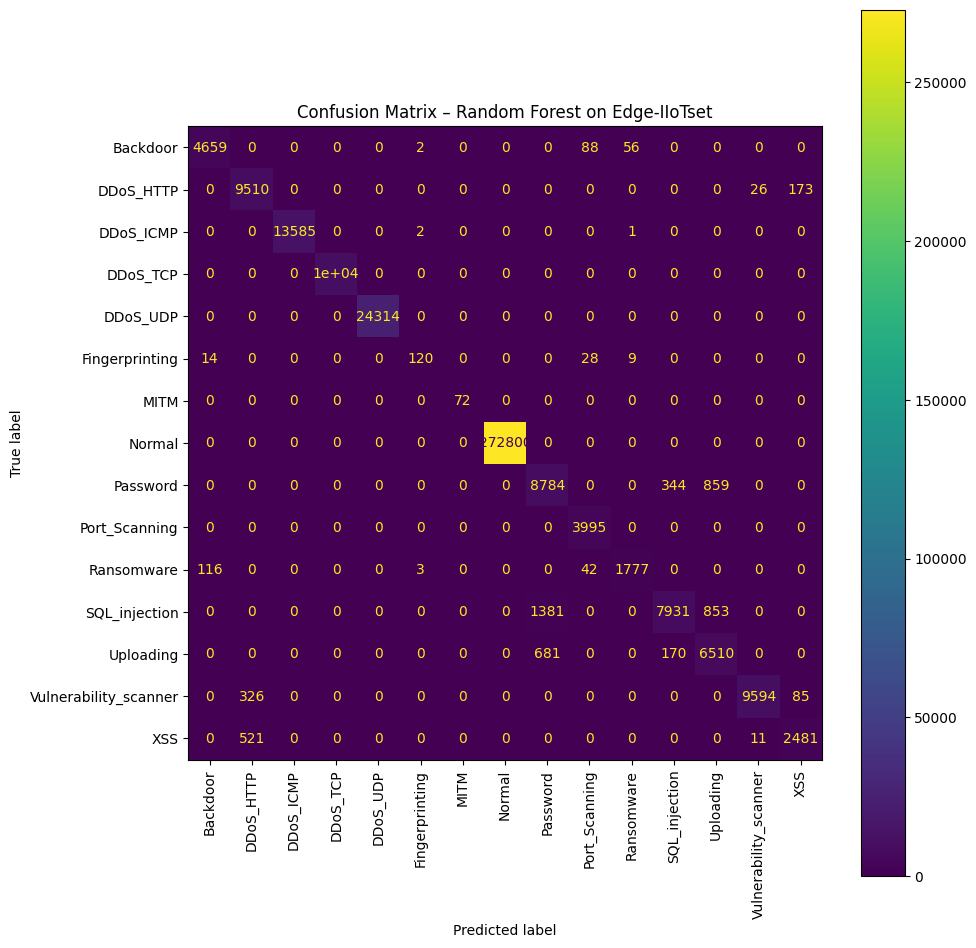

In [17]:
y_pred = rf.predict(X_test_scaled)

print("Classification report (multi-class APT / attack types):")
print(classification_report(y_test, y_pred))

# Confusion matrix
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix – Random Forest on Edge-IIoTset")
plt.tight_layout()
plt.show()


## 9. Feature importance – top contributing features

Inspecting feature importance helps with later **model compression and edge deployment**,
by focusing on the most relevant subset of features.


Top features:
tcp.ack: 0.0795
mqtt.topic-0.0: 0.0699
mqtt.conack.flags-0.0: 0.0599
Attack_label: 0.0598
mqtt.protoname-0.0: 0.0580
dns.qry.name.len-0.0: 0.0529
udp.stream: 0.0513
tcp.seq: 0.0474
mqtt.protoname-0: 0.0415
tcp.flags: 0.0398
dns.qry.name.len-0: 0.0384
tcp.len: 0.0362
icmp.checksum: 0.0352
tcp.ack_raw: 0.0305
mqtt.topic-0: 0.0298
http.referer-0.0: 0.0269
tcp.checksum: 0.0266
icmp.seq_le: 0.0264
mqtt.conack.flags-0: 0.0264
http.referer-0: 0.0257


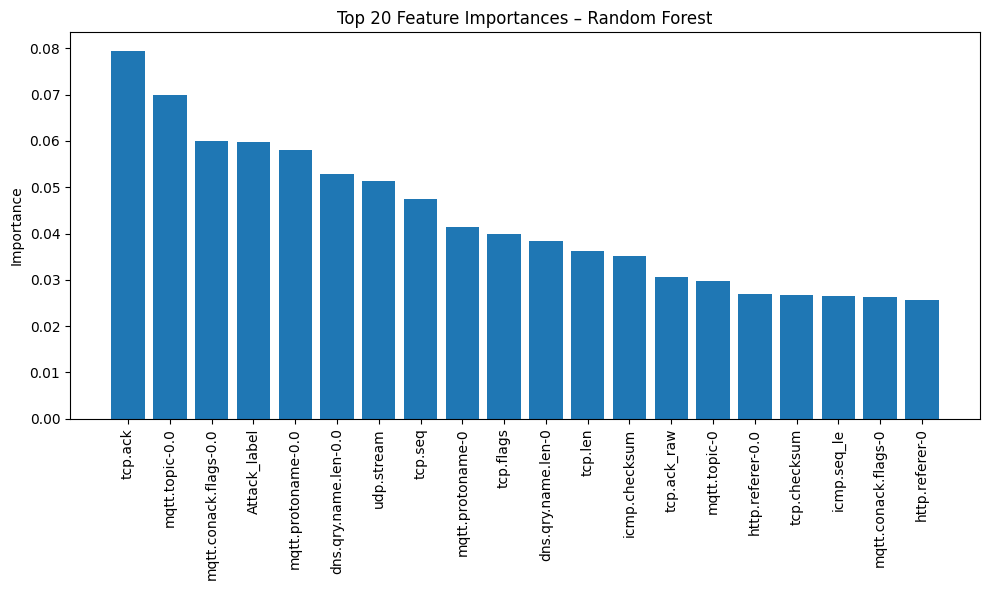

In [18]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
top_indices = indices[:top_n]
top_features = X.columns[top_indices]
top_importances = importances[top_indices]

print("Top features:")
for name, score in zip(top_features, top_importances):
    print(f"{name}: {score:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(top_n), top_importances)
plt.xticks(range(top_n), top_features, rotation=90)
plt.ylabel("Importance")
plt.title("Top 20 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()


## 10. Save model and scaler for edge / gateway deployment

We persist the trained Random Forest model and the StandardScaler using `joblib`.
These files can be loaded later in a lightweight Python service at the gateway or edge device.


In [19]:
model_path = 'edge_iiot_rf_model.joblib'
scaler_path = 'edge_iiot_scaler.joblib'

joblib.dump(rf, model_path)
joblib.dump(scaler, scaler_path)

print(f"Saved Random Forest model to {model_path}")
print(f"Saved StandardScaler to {scaler_path}")


Saved Random Forest model to edge_iiot_rf_model.joblib
Saved StandardScaler to edge_iiot_scaler.joblib


## 11. Example: loading the model and making predictions

This simulates how an **edge node or smart-city gateway** would load the trained model
and make predictions on new feature vectors (e.g., aggregated flow statistics).


In [20]:
# Reload model and scaler
loaded_rf = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)

# Take a small sample from the test set as a stand-in for new data
sample_X = X_test.iloc[:5]
sample_y = y_test.iloc[:5]

sample_X_scaled = loaded_scaler.transform(sample_X)
sample_pred = loaded_rf.predict(sample_X_scaled)

print("Ground truth labels:", list(sample_y))
print("Predicted labels:", list(sample_pred))


Ground truth labels: ['Normal', 'Normal', 'Normal', 'Normal', 'DDoS_HTTP']
Predicted labels: ['Normal', 'Normal', 'Normal', 'Normal', 'DDoS_HTTP']


## 12. Notes on sequence-aware and federated learning extensions

- This notebook implements the **core centralized ML module** using a lightweight Random Forest
  over the DNN-EdgeIIoT preprocessed feature set.
- To move towards **sequence-aware APT detection**, future work can:
  - Aggregate flows into time-ordered sequences per device or session.
  - Feed sequences into compact GRU/TCN models for stage-wise APT detection.
- To integrate **federated learning (FL)**, each smart-city domain (or edge gateway) would:
  - Maintain local data and train local models on its own Edge-IIoT-style traffic.
  - Periodically send model updates (not raw data) to an aggregator using algorithms like FedAvg.

These extensions are aligned with the **federated-ready, privacy-preserving APT detection framework**
described conceptually in the thesis / methodology chapter.
